<a href="https://colab.research.google.com/github/Utkarsh87/Beginner-CNN-Projects/blob/master/Image_Classification_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using CNN to classify images as dog or cat, trained on a subset of the kaggle dataset with the same name.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-03-29 09:59:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   261MB/s    in 0.3s    

2020-03-29 09:59:52 (261 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Use the Kaggle Dogs vs Cats dataset, but only a subset of it(2000 out of 25000 images)

In [0]:
import os
import zipfile
import cv2

dir_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(dir_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

This cell extracts contents out of the zipped file, base directory now contains sub-directories containing train and validation datasets

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Further separate both datasets into cat and dog

train_dir_dog = os.path.join(train_dir, 'dogs')
train_dir_cat = os.path.join(train_dir, 'cats')
validation_dir_dog = os.path.join(validation_dir, 'dogs')
validation_dir_cat = os.path.join(validation_dir, 'cats')

In [21]:
print("Total training images for dogs: ", len(os.listdir(train_dir_dog)))
print("Total training images for cats: ", len(os.listdir(train_dir_cat)))
print("Total validation images for dogs: ", len(os.listdir(validation_dir_dog)))
print("Total validation images for cats: ", len(os.listdir(validation_dir_cat)))

Total training images for dogs:  1000
Total training images for cats:  1000
Total validation images for dogs:  500
Total validation images for cats:  500


1. Data preprocessing
Data generators read images from source folder, convert them into tensors and feed them into the network.
Two such data generators are set up, one each for training and validation datasets, they will yield batches of 20 images, each of size 80*80 .
Normalisation is done using the rescale param.
2. Data Augmentation
Achieved by rotating, flipping, shearing transformations, random zooming into the pictures etc.

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalise pixel values
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size=(80, 80),             #resizes training images to 80*80
                                              batch_size=20,
                                              class_mode='binary')
validation_gen = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(80, 80),   #resizes validation images to 80*80
                                                        batch_size=20,
                                                        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [120]:
print(train_gen)

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
tf.__version__

'2.2.0-rc1'

Build the model.

In [129]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', use_bias=True, input_shape=(80, 80, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='elu', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='elu', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 78, 78, 32)        896       
_________________________________________________________________
batch_normalization_127 (Bat (None, 78, 78, 32)        128       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_127 (Dropout)        (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_128 (Bat (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 18, 18, 64)      

In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.0001, nesterov=True, name='SGD', clipvalue=0.5)
# loss = tf.keras.losses.binary_crossentropy(label_smoothing=0.2)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Fit the training data

In [0]:
epochs = 30

In [132]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=1e-5)]
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=100, callbacks=callbacks, validation_data=validation_gen, validation_steps=50, verbose=1)

Epoch 1/30
100/100 [==============================] - 47s 473ms/step - loss: 0.9884 - accuracy: 0.5220 - val_loss: 0.7624 - val_accuracy: 0.5010 - lr: 0.0050
Epoch 2/30
100/100 [==============================] - 47s 470ms/step - loss: 0.9050 - accuracy: 0.5400 - val_loss: 0.9317 - val_accuracy: 0.5030 - lr: 0.0050
Epoch 3/30
100/100 [==============================] - 47s 467ms/step - loss: 0.8157 - accuracy: 0.5615 - val_loss: 0.7048 - val_accuracy: 0.5630 - lr: 0.0050
Epoch 4/30
100/100 [==============================] - 47s 473ms/step - loss: 0.7778 - accuracy: 0.5660 - val_loss: 0.6725 - val_accuracy: 0.5870 - lr: 0.0050
Epoch 5/30
100/100 [==============================] - 47s 474ms/step - loss: 0.7527 - accuracy: 0.5600 - val_loss: 0.6569 - val_accuracy: 0.5930 - lr: 0.0050
Epoch 6/30
100/100 [==============================] - 47s 474ms/step - loss: 0.7135 - accuracy: 0.5690 - val_loss: 0.6495 - val_accuracy: 0.6010 - lr: 0.0050
Epoch 7/30
100/100 [==============================] 

Visualise training and validation loss and accuracy

Text(0.5, 1.0, 'Training and Validaiton loss per epoch')

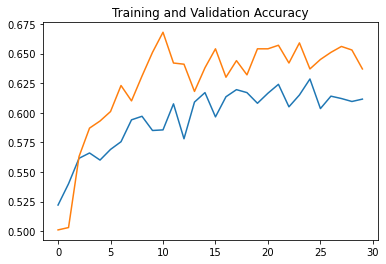

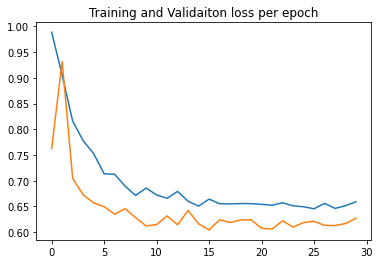

In [133]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot retrieved data
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Training and Validation Accuracy")

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validaiton loss per epoch")

In [144]:
# Top 5 metrics

from statistics import mean

val_acc.sort()
top5val_acc = val_acc[-5:]
val_loss.sort()
top5val_loss = val_loss[:5]

print("Top 5 validation accuracy: ",mean(top5val_acc))
print("Top 5 validation loss: ", mean(top5val_loss))

Top 5 validation accuracy:  0.6587999939918519
Top 5 validation loss:  0.6081268310546875
